25, 32
24.2, 31.5
22, 34
20.5, 34
End.


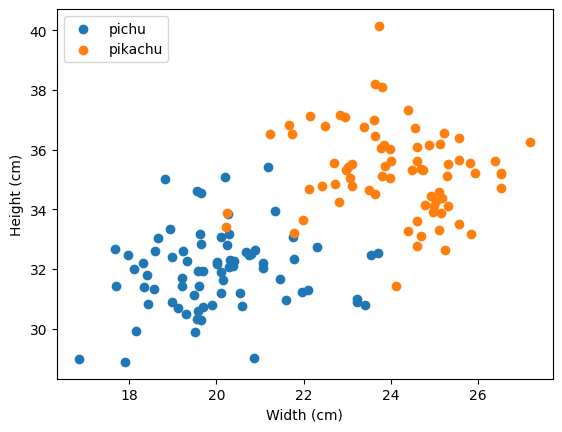

In [23]:
import matplotlib.pyplot as plt
#import json



def get_pokemons():
    '''Returns a dictionry of all pokemons recognized by the program, 
    with their label as key.'''
    return {0: "pichu", 1: "pikachu"}



"""def label_to_pokemon(label):
    pokemons = get_pokemons()
    return pokemons[label]"""


def filtered_measurements(measurements, label):
    '''Returns a list of measurements (dictionaries) 
    with a matching label'''
    filtered = []
    for measurement in measurements:
        if measurement["label"] == label:
            filtered.append(measurement)
    return filtered


def separated_measurements(measurements):
    '''Returns a dictionary with two lists containing the measured 
    heights and widths from the parameter measurements. Restructuring 
    measurement data in this way is helpful when plotting data points.'''
    measured_widths = []
    measured_heights = []

    for measurement in measurements:
        measured_widths.append(measurement["width"])
        measured_heights.append(measurement["height"])
    
    return {
        "widths": measured_widths,
        "heights": measured_heights
    }




def load_measurements():
    '''Returns a list with an item for each pokemon measured. 
    Each item is a dictionary with keys "width", "height" & "label".'''

    with open("./datapoints.txt") as file:
        lines = file.readlines()

    # Manage file contents outside with statement above in order to 
    # close the file asap.

    # remove "\n" at end of each line:
    lines = [line.rstrip() for line in lines]
    # remove first line (header):
    lines = lines[1:]

    measurements = []

    # interpret data in each line as a measurement
    for line in lines:
        line_data = line.split(", ")
        width = float(line_data[0])
        height = float(line_data[1])
        label = int(line_data[2])
        measurement = {
            "width": width,
            "height": height,
            "label": label
        }
        measurements.append(measurement)
        
    return measurements



def plot_measurements(measurements):
    ''' Plots the data points from measurements using matplotlib. 
    Each plotted point is a measurement, with x value representing width 
    and y value representing height. Each pokemon "species" is represented 
    with a different color.'''
    # plot all the points of one pokemon species at a time
    for label, pokemon in get_pokemons().items():
        filtered = filtered_measurements(measurements, label)

        #print(f"{label}-{pokemon}: {len(filtered)}")

        # separate measurements into two lists ("height" and "width")
        # for plt.scatter()
        # (This could probably be solved with numpy instead...)
        separated = separated_measurements(filtered)
        plt.scatter(
            x = separated["widths"],
            y = separated["heights"],
            label = pokemon
        )

    # Explain axis values with labels:
    plt.xlabel("Width (cm)")
    plt.ylabel("Height (cm)")

    # show a legend in upper left corner that explains 
    # which pokemon each color represents
    plt.legend(loc="upper left")

    # Not sure what the point of this method is...
    #plt.show()



def load_test_measurements():
    with open("./testpoints.txt") as file:
        lines = file.readlines()
    # Manage file contents outside with statement above in order to 
    # close the file asap.

    # remove "\n" at end of each line:
    lines = [line.rstrip() for line in lines]
    # remove first line (header):
    lines = lines[1:]

    measurements = []

    # interpret data in each line as a measurement
    for line in lines:
        # remove line numbering and parentheses
        cleaned_line = line[4:-1]
        #print(cleaned_line)
        line_data = cleaned_line.split(", ")
        width = float(line_data[0])
        height = float(line_data[1])
        measurement = {
            "width": width,
            "height": height
        }
        measurements.append(measurement)
        
    return measurements




measurements = load_measurements()
#print(f"{len(measurements) = }")
#serialized_measurements = json.dumps(measurements, indent=4)
#print(serialized_measurements)

plot_measurements(measurements)

test_measurements = load_test_measurements()
print(f"{test_measurements = }")

print("End.")